In [10]:
import setup
import numpy as np
import pandas as pd
from thalpy.constants import paths
from matplotlib import pyplot as plt
from thalpy.analysis import masks, pc, plotting, feature_extraction, fc
from thalpy import base
import nibabel as nib
import seaborn as sns
import os

masker = masks.get_binary_masker(masks.MOREL_PATH)

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogrammasks

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hier_cluster(task_matrix, n_clusters=None):
    if n_clusters is None:
        distance_threshold = 0
    else:
        distance_threshold = None
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    cluster = model.fit(np.mean(task_matrix, axis=2).swapaxes(0, 1))
    if distance_threshold is not None:
        plot_dendrogram(model)
    return cluster



In [12]:
from sklearn.cluster import KMeans
VOXELS = 2227

def cluster_sub(sub_matrix, k):
    sub_correlation_matrix = np.corrcoef(sub_matrix)
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(sub_correlation_matrix)

    # plus 1 is just for plotting purposes, labels with 0 show up not having color
    return model.labels_ + 1, model

def consensus_cluster(task_matrix, masker, output_dir, label=""):
    # consensus clustering

    for k_cluster in range(2, 8):
        consensus_matrix = np.empty([VOXELS, VOXELS, task_matrix.shape[-1]])
        for i in range(task_matrix.shape[-1]):
            sub_cluster, model = cluster_sub(task_matrix[:, :, i], k_cluster)
            coassignment_matrix = np.empty([VOXELS, VOXELS])
            for j in range(VOXELS):
                for k in range(VOXELS):
                    if sub_cluster[j] == sub_cluster[k]:
                        coassignment_matrix[j][k] = 1
                    else:
                        coassignment_matrix[j][k] = 0
            consensus_matrix[:, :, i] = coassignment_matrix

        mean_matrix = consensus_matrix.mean(2)
        final_consensus_cluster, model = cluster_sub(mean_matrix, k_cluster)
        final_consensus_cluster = masker.inverse_transform(final_consensus_cluster)
        nib.save(final_consensus_cluster, output_dir + f"consensus_cluter_{label}_{k_cluster}.nii")
        plotting.plot_thal(final_consensus_cluster)

def plot_clusters(sub_matrix):
    ks = range(2, 10)
    inertias = []
    for k in ks:
        cluster_atlas, model = cluster_sub(sub_matrix, k)
        plotting.plot_roi(cluster_atlas, cmap=plt.cm.get_cmap("tab10"))
        plotting.show()

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, "-o", color="black")
    plt.xlabel("number of clusters, k")
    plt.ylabel("inertia")
    plt.xticks(ks)
    plt.show()

In [13]:
# task_matrix, tstat_task_matrix, masker = setup.setup_mdtb('block', is_setup_block=True)
# zscored_task_matrix = setup.zscore_subject_2d(task_matrix)
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy', zscored_task_matrix)

MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
MDTB_DIR_TREE = base.DirectoryTree(MDTB_DIR)
MDTB_ANALYSIS_DIR = MDTB_DIR + 'analysis/'
stim_config_df = pd.read_csv(MDTB_DIR + paths.DECONVOLVE_DIR + paths.STIM_CONFIG)
CONDITIONS_LIST = stim_config_df["Stim Label"].tolist()

TASK_LIST = list(set(stim_config_df["Group"].to_list()))
TASK_LIST.remove("Rest")

# conditions_matrix, tstat_conditions_matrix, masker = setup.setup_mdtb('_norest', is_setup_block=False)
# zscored_mdtb_matrix = setup.zscore_subject_2d(conditions_matrix)
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy', zscored_mdtb_matrix)

zscored_mdtb_task = np.load(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy')
zscored_mdtb_conditions = np.load(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy')


# FC MDTB
# cortical_masker = masks.get_roi_masker(masks.SCHAEFER_YEO7_PATH)
# fc_data = fc.FcData(MDTB_DIR, masker, cortical_masker, 'fc_thal_schaef', sessions=['ses-rest'], cores=16)
# fc_data.calc_fc()

0: Verbal2Back
1: TheoryOfMind
2: Motor
3: NatureMovie
4: Interval
5: MentalRotation
6: Rules
7: IAPSaffective
8: ResponseAlternativesMotor
9: Math
10: BiologicalMotion
11: VisualSearch
12: ObjectNBackTask
13: LandscapeMovie
14: Stroop
15: SpatialMap
16: ActionObservation
17: Language
18: Go/NoGo
19: AnimatedMovie
20: IAPSemotion
21: ObjectViewing
22: MotorImagery
23: SpatialImagery
24: WordPrediction
k: 0  group: ['Rules', 'IAPSaffective', 'BiologicalMotion', 'ObjectNBackTask', 'IAPSemotion', 'MotorImagery', 'WordPrediction']
k: 1  group: ['MentalRotation', 'ResponseAlternativesMotor', 'Stroop', 'AnimatedMovie', 'ObjectViewing', 'SpatialImagery']
k: 2  group: ['TheoryOfMind', 'Motor', 'NatureMovie', 'VisualSearch', 'ActionObservation', 'Language']
k: 3  group: ['Interval', 'Math', 'SpatialMap']
k: 4  group: ['Go/NoGo']
k: 5  group: ['Verbal2Back', 'LandscapeMovie']


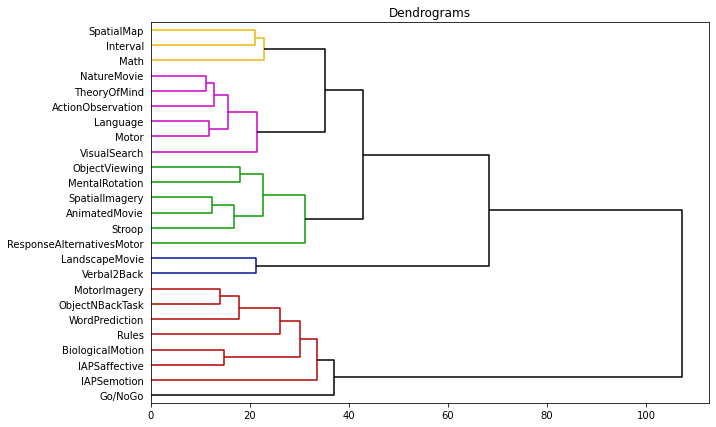

In [14]:
from thalpy.constants import paths

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['#b30000','#001299', '#089900', '#cc00c9', '#edb705']) 
dend = shc.dendrogram(shc.linkage(np.swapaxes(np.mean(zscored_mdtb_task, axis=2), 0, 1), method='ward'), color_threshold=35, above_threshold_color='black', orientation="right", labels=TASK_LIST)

conditions_cluster = hier_cluster(zscored_mdtb_task, n_clusters=6)

# dendrogram(conditions_cluster)
for i, item in enumerate(TASK_LIST):
    print(f"{i}: {item}")

for k in np.arange(len(np.unique(conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(TASK_LIST) if k == conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')

/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


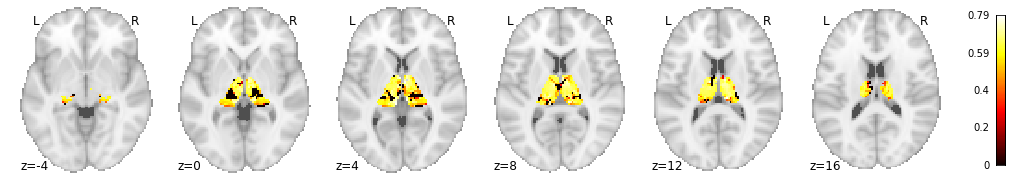

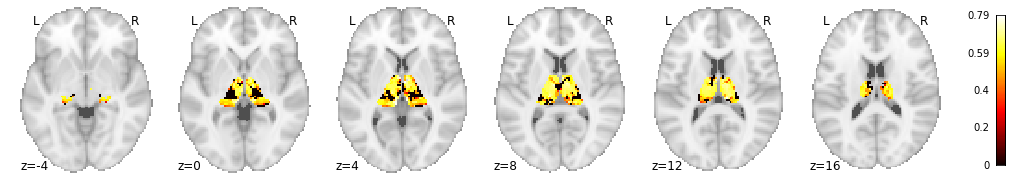

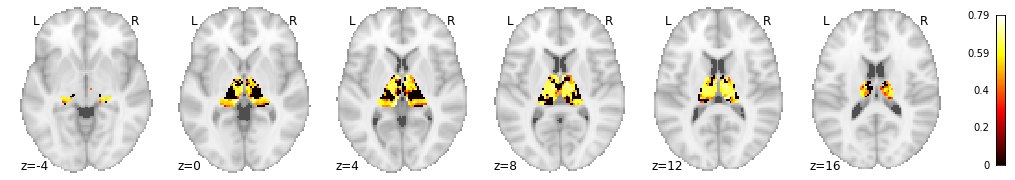

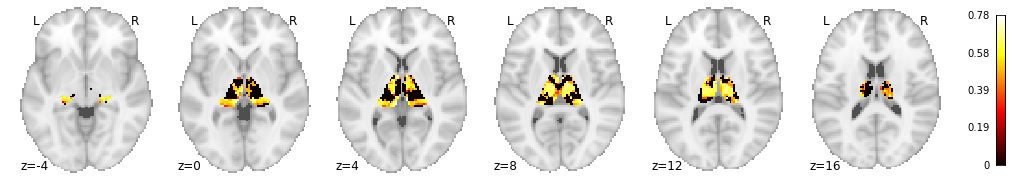

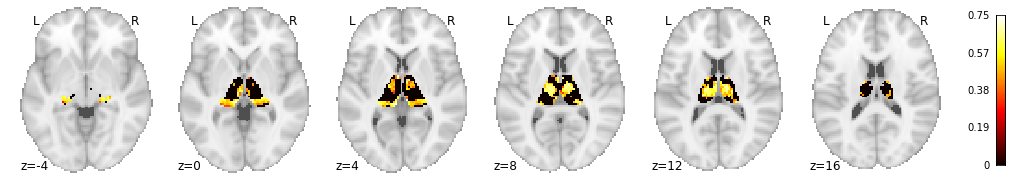

In [15]:
thresholds = [70, 75, 80, 85, 90]
pc_matrix = pc.pc_subject(np.mean(zscored_mdtb_task, axis=2), conditions_cluster.labels_, thresholds=thresholds)
pc_matrix = np.where(np.isnan(pc_matrix), 0.001, pc_matrix)
pc_matrix = np.where(pc_matrix <= 0, 0.001, pc_matrix)

for i, threshold in enumerate(thresholds):
    masker.fit()
    pc_img = masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)
    nib.save(pc_img, MDTB_DIR_TREE.analysis_dir + f"pc_{threshold}.nii")

Explained variance:
[0.49422765 0.22373263 0.07304692 0.05084266 0.03473523 0.02276043
 0.01554752 0.01323701 0.01273611 0.00932534]


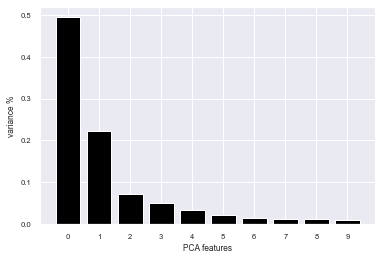

                                  0         1         2         3         4  \
Verbal2Back               -0.109025  0.180565 -0.479413  0.298831 -0.360200   
TheoryOfMind              -0.105403 -0.188958 -0.012041  0.049715 -0.132591   
Motor                     -0.064864 -0.136485  0.057479  0.096580 -0.146336   
NatureMovie               -0.080575 -0.176214 -0.053789 -0.016803  0.011678   
Interval                  -0.238421 -0.333790 -0.180126  0.093768 -0.011658   
MentalRotation             0.060554 -0.175167 -0.106397 -0.166514  0.015731   
Rules                      0.249122  0.075354 -0.099607 -0.099327 -0.419690   
IAPSaffective              0.315565 -0.112435  0.161290 -0.179735 -0.338644   
ResponseAlternativesMotor  0.096386 -0.166564  0.431605  0.156335 -0.144623   
Math                      -0.173234 -0.314162  0.246121  0.194231  0.022407   
BiologicalMotion           0.330223 -0.090945  0.164614  0.025567 -0.332990   
VisualSearch              -0.112587 -0.070249  0.184

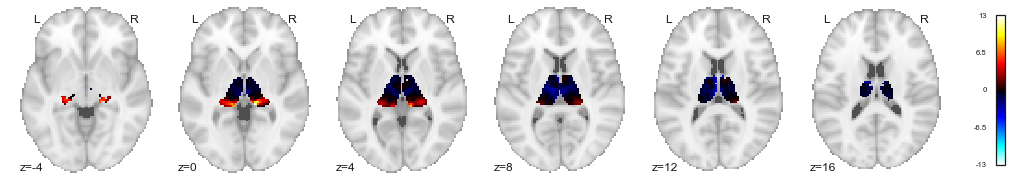

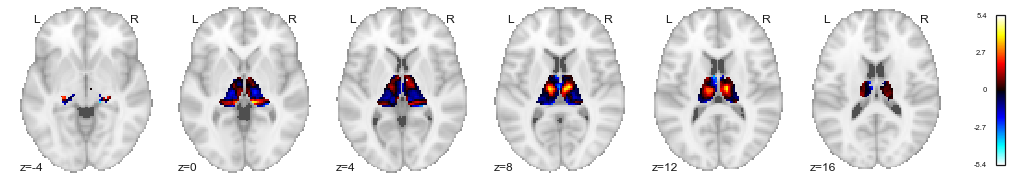

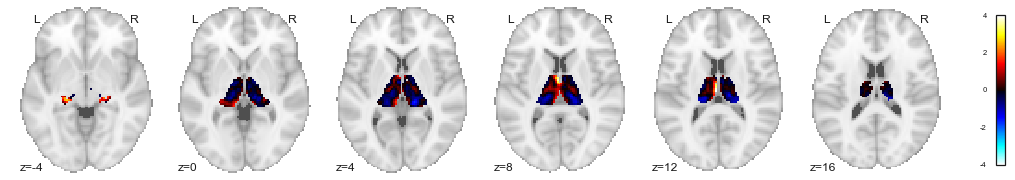

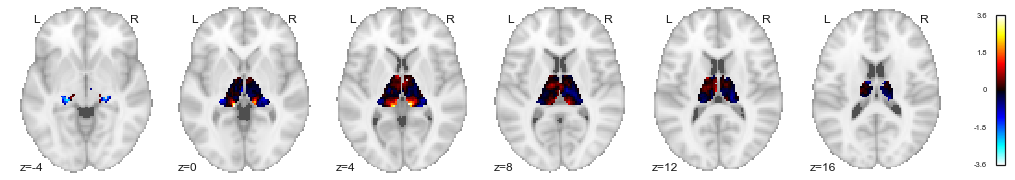

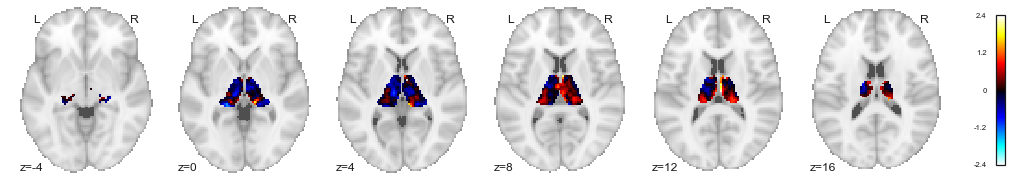

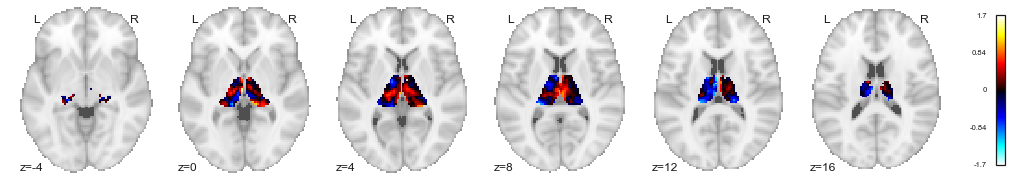

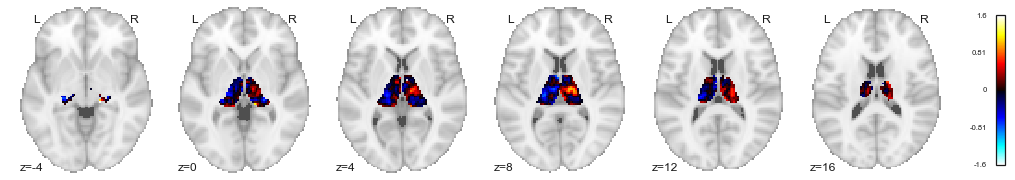

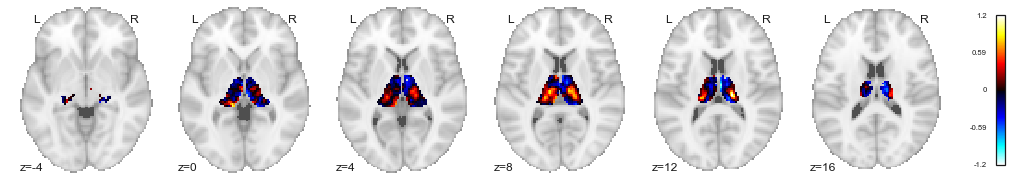

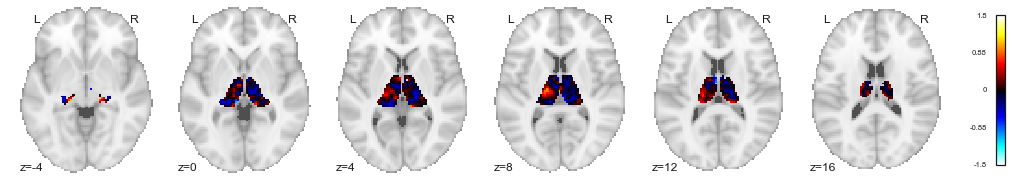

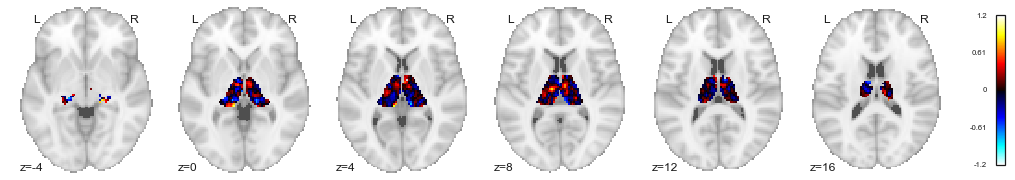

In [47]:

from pca import pca
from scipy import stats
from scipy.spatial import distance
from IPython.display import display, HTML

os.chdir(MDTB_DIR_TREE.analysis_dir)
# feature_extraction.compute_PCA(np.mean(zscored_mdtb_conditions, axis=2), masker=masker, output_name='pca_mdtb_conditions', var_list=CONDITIONS_LIST)
pca_comps, loadings, correlated_loadings = feature_extraction.compute_PCA(np.mean(zscored_mdtb_task, axis=2), output_name='pca_mdtb', var_list=TASK_LIST)
pca_comps[:, 1] = pca_comps[:, 1] * -1
loadings[:, 1] = loadings[:, 1] * -1
correlated_loadings[1] = correlated_loadings[1] * -1

loadings_df = pd.DataFrame(loadings, index=TASK_LIST)
summary_df = loadings_df.describe()
var_df = loadings_df.var(axis=0).rename("var")
summary_df = summary_df.append(var_df)
display(HTML(summary_df.to_html()))


all_comps_task_space = np.empty([len(TASK_LIST), pca_comps.shape[0], pca_comps.shape[1]])
for index in range(len(pca_comps)):
    if index == 10:
        break

    # save PCs back into nifti image and visualize
    comp_array = pca_comps[:, index]
    img = masker.inverse_transform(comp_array)
    nib.save(img, f"pca_mdtb_pc{index}.nii")
    plotting.plot_thal(img)

    # save each pc in task space
    pc_task_space = np.dot(np.swapaxes(loadings.T, 0, 1)[:, index, np.newaxis], np.swapaxes(pca_comps, 0,1)[np.newaxis, index, :])
    # pc_task_space_imgs = masker.inverse_transform(pc_task_space)
    # nib.save(pc_task_space_imgs, f"pca_task_space_pc{index}.nii")
    all_comps_task_space[:, :, i] = pc_task_space


    # for task in range(len(TASK_LIST)):
    #     print(distance.mahalanobis(pc_task_space[task, :], comp_array, np.cov(pc_task_space[:, :].T)))


In [17]:
### PCA comps correlation to PC

pc_rs = nib.load('/data/backed_up/shared/ROIs/PC.4floor.nii.gz')
pc_masked = masker.transform(pc_rs)
for comp in np.arange(pca_comps.shape[1]):
    f_corr = np.corrcoef(pc_matrix[:, 2], pca_comps[:, comp])[0, 1] 
    rs_corr = np.corrcoef(pc_masked, pca_comps[:, comp])[0, 1]
    print(comp)
    print(f_corr)
    print(rs_corr)

0
0.028983787290785653
-0.24927078652120105
1
0.6278720540453105
0.2509827498439394
2
0.23432838752285265
0.13803636456458884
3
0.03822321401467135
0.30951301762932326
4
-0.0003100018537859049
0.13363610407529544
5
-0.11491141512279458
0.02275031808447228
6
0.03914571859067229
0.09454817515961103
7
0.04931580544077717
-0.11839670903500302
8
0.06107747810732921
-0.05895473898721385
9
0.03251404255420575
0.0398178875185719


25


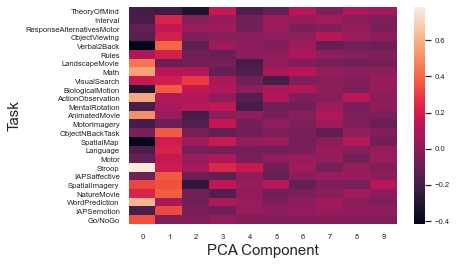

In [34]:
### Loadings Heatmap

import seaborn as sns 

df = pd.read_csv('/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/analysis/pca_mdtb_task_correlated_loadings.csv').set_index('Task')
print(len(df.index))
df["1"] = df["1"] * -1
sns.set(font_scale=0.7)
ax = sns.heatmap(df, xticklabels=True, yticklabels=True,)
plt.xlabel('PCA Component', fontsize=15)
plt.ylabel('Task', fontsize=15)

plt.savefig(MDTB_ANALYSIS_DIR + 'pca_heatmap.png', transparent=True)
plt.show()

In [40]:
### Predicted Corticals Analysis

rs = fc.load(MDTB_ANALYSIS_DIR + "fc_thal_schaef.p")
beta_data = np.load(MDTB_ANALYSIS_DIR + "beta_cortical.npy")
subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

# Indiviuals
# rs_data doesn't match up -- not all subjects have rs data.
def corr_sub(rs, mdtb_task, beta_data):
    sub_cor_array = np.zeros([len(TASK_LIST), len([x for x in rs.fc_subjects if x is not None]) - 2]) 
    
    array_index = 0 
    for rs_index in range(len(rs.fc_subjects)):
        fc_subject = rs.fc_subjects[rs_index]
        if fc_subject is None:
            continue
        try:
            beta_index = subjects.to_subargs_list().index(fc_subject.name)
        except:
            continue
        
        sub_rs = rs.fc_subjects[rs_index].seed_to_voxel_correlations[:, :]
        predicted_corticals = np.dot(np.swapaxes(mdtb_task[:, :, beta_index], 0, 1), sub_rs)
        beta_corticals = np.swapaxes(beta_data[:, :, beta_index], 0, 1)
        for i, task in enumerate(TASK_LIST):
            corr = np.corrcoef(predicted_corticals[i, :], beta_corticals[i, :])[0, 1]
            sub_cor_array[i, array_index] = corr
            
            
        array_index += 1
    
    return sub_cor_array

sub_cor_array = corr_sub(rs, zscored_mdtb_task, beta_data)


# Averaged across subjects
def corr_avg(rs, mdtb_task, beta_data):
    avg_predicted_corticals = np.dot(np.swapaxes(np.mean(zscored_mdtb_task, axis=2), 0, 1), np.mean(rs.data, axis=2))
    avg_beta_corticals = np.swapaxes(np.mean(beta_data, axis=2), 0, 1)
    cor_array = np.empty([len(TASK_LIST)])
    for i, task in enumerate(TASK_LIST):
        cor = np.corrcoef(avg_predicted_corticals[i, :], avg_beta_corticals[i, :])[0, 1]
        cor_array[i] = cor

    return cor_array

avg_cor_array = corr_avg(rs, zscored_mdtb_task, beta_data)
print(np.max(avg_cor_array) - np.min(avg_cor_array))

# Null Models
k = 100
null_corr_array = np.empty([k, len(TASK_LIST)])
for i in np.arange(k):
    print(i)
    avg_mdtb_thal = np.mean(zscored_mdtb_task, axis=2)
    for j in np.arange(len(TASK_LIST)):
        print(np.random.permutation(avg_mdtb_thal[:, j]))
        print(np.random.permutation(avg_mdtb_thal[:, j]).shape)
        avg_mdtb_thal[:, j] = np.random.permutation(avg_mdtb_thal[:, j])
    null_corr_array[i, :] = corr_avg(rs, avg_mdtb_thal, beta_data)

# evoked response to 1
sub_evoked_1 = corr_sub(rs, np.ones(zscored_mdtb_task.shape), beta_data)
avg_evoked_1 = corr_avg(rs, np.ones(zscored_mdtb_task.shape), beta_data)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0.48126734583879044
0
[-0

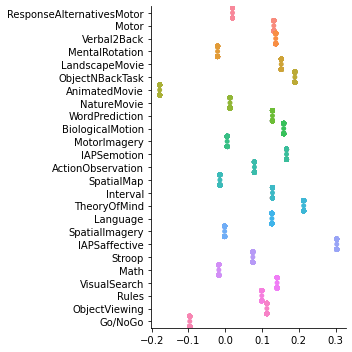

/opt/anaconda3-2020.07/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


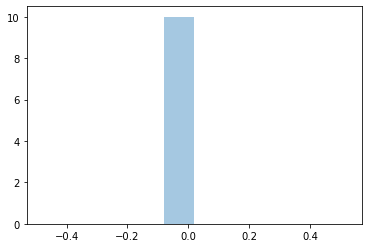

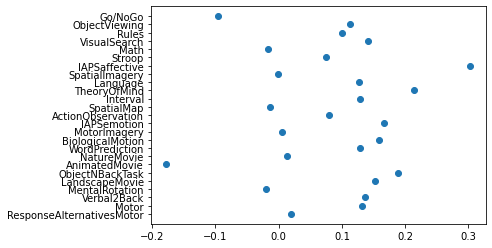

In [38]:
cor_df = pd.DataFrame(null_corr_array, columns=TASK_LIST)
sns.catplot(kind='swarm', orient="h", data=cor_df)
plt.show()
sns.distplot(null_corr_array[:, 0])
plt.show()
plt.scatter(avg_cor_array, TASK_LIST)

In [8]:
# consensus_cluster(zscored_mdtb_task, masker, MDTB_DIR_TREE.analysis_dir, label="task")
# consensus_cluster(zscored_mdtb_conditions, masker, MDTB_DIR_TREE.analysis_dir, label="conditions")

In [9]:

IBC_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/IBC/"
IBC_CONDITIONS_DF = pd.read_csv(
    "/mnt/nfs/lss/lss_kahwang_hpc/scripts/ibc_authors/ibc_data/conditions.tsv",
    sep="\t",
)
IBC_CONDITIONS_DF.at[253, "contrast"] = "null"
IBC_GLM_DIR = IBC_DIR + "glm/"
IBC_DIR_TREE = base.DirectoryTree(IBC_DIR) 

# setup.setup_ibc("ses-*/res_stats_*_[pa][ap]/z_score_maps/*.nii.gz", "ibc_zscored_conditions.npy", two_runs=True)
# setup.setup_ibc("ses-*/res_stats_*_ffx/effect_size_maps/*.nii.gz", "ibc_conditions.npy")

def filter_ibc(ibc_matrix, IBC_CONDITIONS_DF):
    filtered_ibc = []
    for condition_index in np.arange(ibc_matrix.shape[1]):
        if len(np.where(ibc_matrix[:, condition_index, :] == 0)[0]) > 11000:
            IBC_CONDITIONS_DF = IBC_CONDITIONS_DF.drop(condition_index)
        else:
            filtered_ibc.append(ibc_matrix[:, condition_index, :])

    filtered_ibc_matrix = np.swapaxes(np.swapaxes(np.stack(filtered_ibc), 1, 2), 0, 1)

    return filtered_ibc_matrix, IBC_CONDITIONS_DF


zscored_ibc_conditions = np.load(IBC_DIR_TREE.analysis_dir + 'ibc_zscored_conditions.npy')
zscored_ibc_conditions, IBC_CONDITIONS_DF = filter_ibc(zscored_ibc_conditions, IBC_CONDITIONS_DF)

# ibc_conditions = np.load(IBC_DIR_TREE.analysis_dir + 'ibc_conditions.npy')
# filtered_ibc_matrix, IBC_CONDITIONS_DF = filter_ibc(ibc_conditions, IBC_CONDITIONS_DF)
# zscored_ibc_conditions = setup.zscore_subject_2d(filtered_ibc_matrix)


In [10]:

ibc_conditions_cluster = hier_cluster(zscored_ibc_conditions, n_clusters=10)
# plot_dendrogram(ibc_conditions_cluster)

for k in np.arange(len(np.unique(ibc_conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(IBC_CONDITIONS_DF['contrast'].to_numpy()) if k == ibc_conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')



k: 0  group: ['face_gender', 'face_control', 'face_trusty', 'expression_intention', 'expression_gender', 'expression_control', 'shape', 'face', 'punishment', 'reward', 'story', 'math', 'relational', 'match', 'mental', 'random', '0back_body', '2back_body', '0back_face', '2back_face', '0back_tools', '2back_tools', '0back_place', '2back_place', 'vstm_linear', 'vstm_constant', 'vstm_quadratic', 'talk', 'no_talk', 'lower_meridian', 'upper_meridian', 'lower_right', 'upper_left', 'right_meridian', 'left_meridian', 'upper_right', 'lower_left', 'foveal', 'middle', 'peripheral', 'unattend', 'attend', 'scrambled', 'face-scrambled', 'characters-scrambled', 'scene-scrambled', 'house-scrambled', 'animal-scrambled', 'pseudoword-scrambled', 'tool-scrambled', 'random_string', 'word', 'pseudoword', 'mean-silence', 'animal-silence', 'music-silence', 'nature-silence', 'speech-silence', 'voice-silence', 'go', 'stop', 'task_stay_cue_stay', 'task_switch_cue_switch', 'task_switch_cue_stay', 'task_stay_cue_swi

[0.67562468 0.57398714 0.78116184 ... 0.79512593 0.76977267 0.77207933]
/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(
[0.49928977 0.5886782  0.78116184 ... 0.71112216 0.73815482 0.77207933]
[0.34434146 0.43485688 0.78116184 ... 0.71112216 0.71357639 0.78249703]
[0.00000000e+00 2.22044605e-16 7.27522036e-01 ... 5.93880245e-01
 6.45436629e-01 7.44074817e-01]


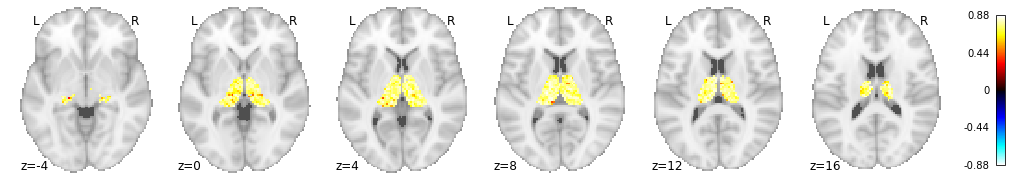

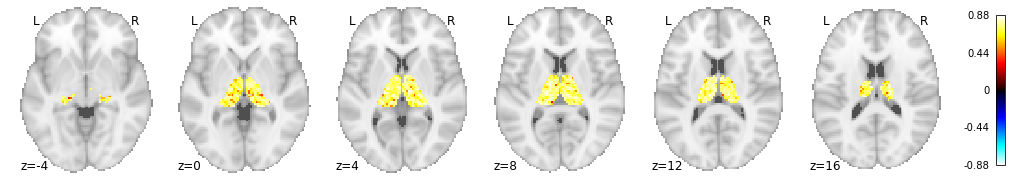

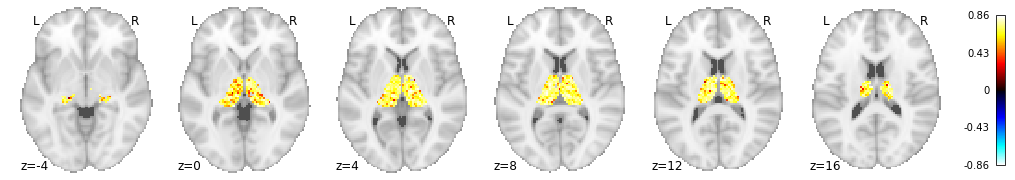

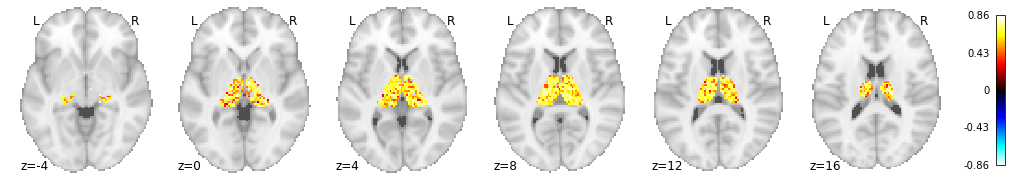

In [11]:
from thalpy.analysis import pc, plotting

thresholds = [70, 75, 80, 85]
ibc_pc_matrix = pc.pc_subject(np.mean(zscored_ibc_conditions, axis=2), ibc_conditions_cluster.labels_,thresholds=thresholds)

for i, threshold in enumerate(thresholds):
    print(ibc_pc_matrix[:, i])
    pc_img = masker.inverse_transform(ibc_pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)

Explained variance:
[0.09238858 0.09159794 0.07494163 0.06862599 0.05636973 0.0454221
 0.04407944 0.04108556 0.03866424 0.03624531 0.03477694 0.03364162
 0.02828317 0.02639237 0.02501796 0.02389269 0.0213558  0.02030951
 0.01971147 0.01813705 0.01645862 0.01491358 0.01487821 0.01407155
 0.01333804 0.01321013 0.01238953 0.01199947]


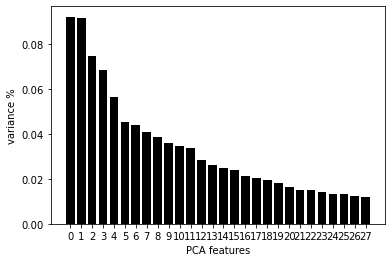

                                     0         1         2         3   \
audio_left_button_press        0.292146 -0.099001  0.044749  0.000022   
audio_right_button_press       0.292146 -0.099001  0.044749  0.000022   
video_left_button_press        0.292146 -0.099001  0.044749  0.000022   
video_right_button_press       0.292146 -0.099001  0.044749  0.000022   
horizontal_checkerboard        0.292146 -0.099001  0.044749  0.000022   
...                                 ...       ...       ...       ...   
incorrect_cue_incorrect_probe  0.000456 -0.013648  0.002735 -0.012514   
ambiguous_intermediate        -0.008885  0.034957  0.005070  0.022659   
unambiguous_direct            -0.008885  0.034957  0.005070  0.022659   
ambiguous_direct              -0.008885  0.034957  0.005070  0.022659   
unambiguous_intermediate      -0.008885  0.034957  0.005070  0.022659   

                                     4         5         6         7   \
audio_left_button_press       -0.009513  0.010702 

array([[-0.62210229, -0.48616563, -0.06061501, ..., -0.23351806,
        -0.09993874,  0.20902341],
       [-1.44245681, -0.64904067, -0.3283104 , ..., -0.32183466,
         0.18778648,  0.10694705],
       [ 1.79774247, -0.06732314, -0.73167545, ..., -0.12505352,
        -0.16823127,  0.24763516],
       ...,
       [ 0.15101665, -1.03101255,  0.10160648, ..., -0.1402977 ,
        -0.15643045,  0.23826713],
       [ 0.09936991, -0.42868139,  0.01367101, ...,  0.17708608,
         0.25386417,  0.18198829],
       [-0.196411  ,  0.3494682 ,  0.16860706, ..., -0.69431978,
         0.70236015, -0.11470198]])

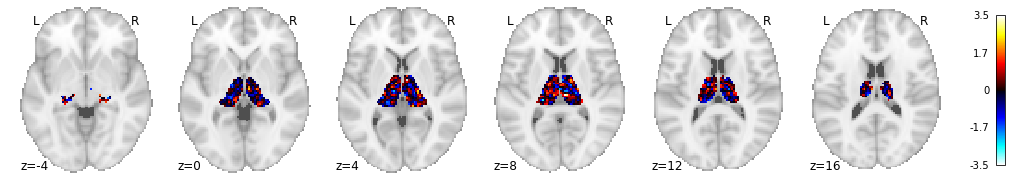

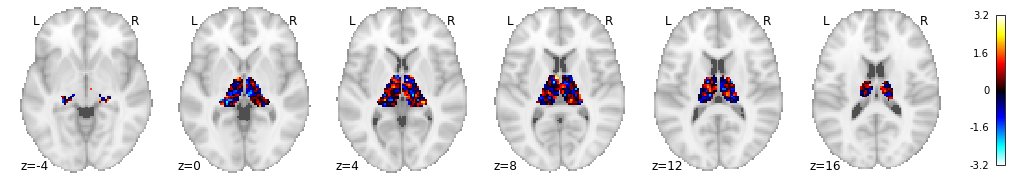

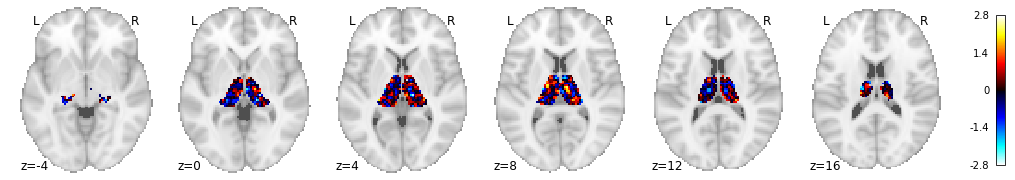

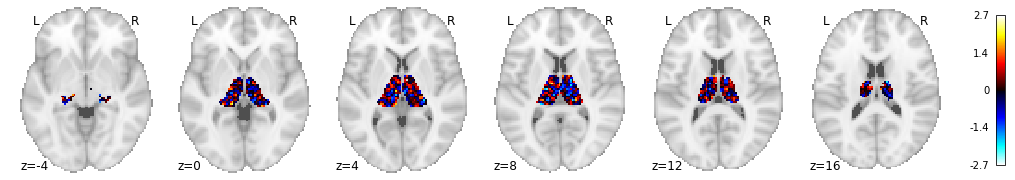

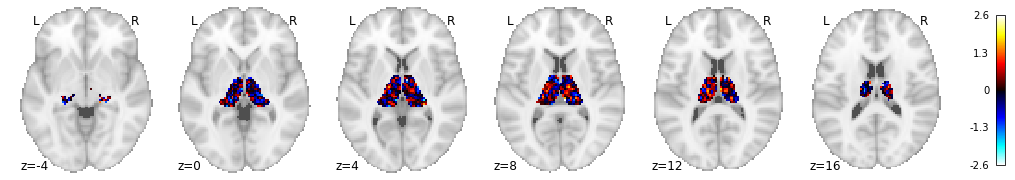

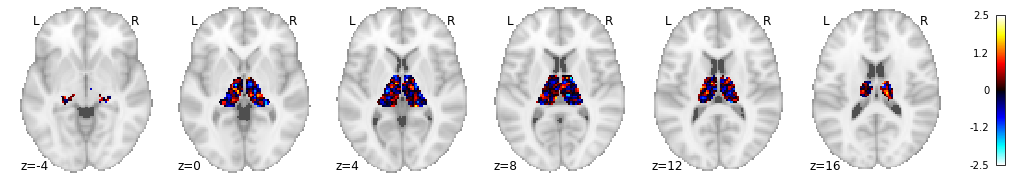

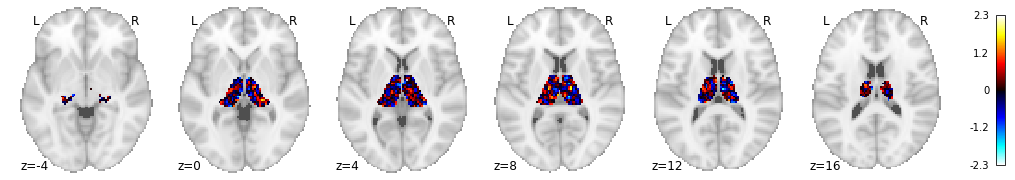

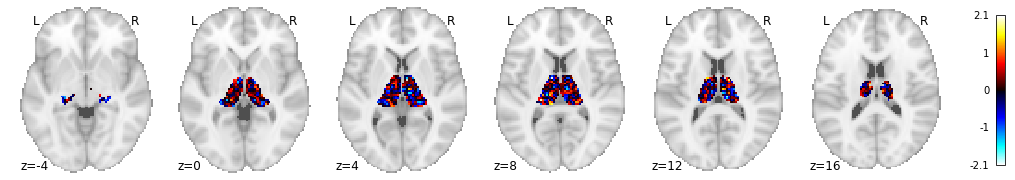

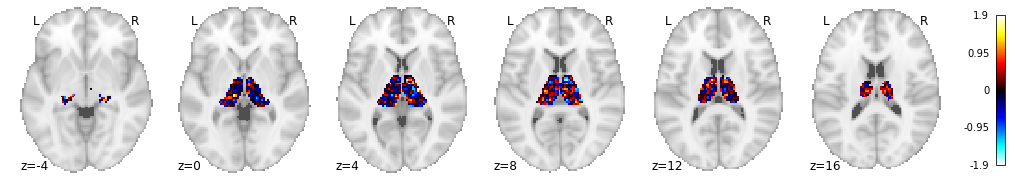

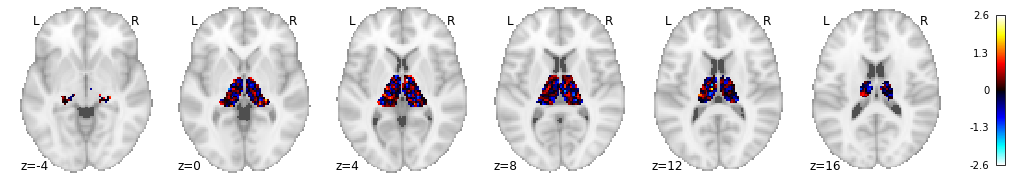

In [12]:
from thalpy.analysis import feature_extraction

os.chdir(IBC_DIR_TREE.analysis_dir)
feature_extraction.compute_PCA(np.mean(zscored_ibc_conditions, axis=2), masker=masker, output_name='pca_ibc', var_list=IBC_CONDITIONS_DF['contrast'].to_numpy())

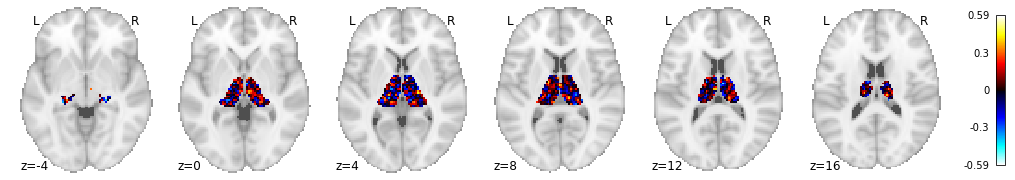

In [13]:
avg_wm_matrix = np.mean(zscored_ibc_conditions[:, IBC_CONDITIONS_DF.loc[IBC_CONDITIONS_DF['task'] == 'hcp_wm'].index, :], axis=2)
avg_wm_matrix = np.mean(avg_wm_matrix, 1)
img = masker.inverse_transform(avg_wm_matrix)

plotting.plot_thal(img)



In [14]:
from thalpy.analysis import fc

# task fc
# for task in IBC_CONDITIONS_DF['task'].unique():
#     print(task)
#     fc_data = fc.FcData(IBC_DIR, masker, masks.get_roi_mask(masks.SCHAEFER_YEO7_PATH), f"task_fc_{task}", bold_dir=IBC_DIR + "glm/", bold_WC=f"res_stats_*{task}_[ap][pa]/residual*", censor=False, is_denoise=False, cores=10)
#     fc_data.calc_fc()